<a href="https://colab.research.google.com/github/Rabia-Akhtr/Large-language-models/blob/main/Large_language_models_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3 - LLM Fine-tuning for Text Classification (AG News)

## Notebook checklist
-  Public dataset + task definition (AG News, 4-class topic classification)
- Preprocessing: BERT tokenizer + train/test usage (+ our train/val split)
-  Baseline model(s): TF-IDF + Logistic Regression (and optional “pretrained BERT only” baseline)
- Fine-tune BERT-style model with torch training loop + optimizer + loss
-  Evaluation: accuracy, precision, recall, F1 + confusion matrix
-  Model selection on validation only (no test leakage)
- Reproducibility artifacts saved (config + results + predictions)
- Error analysis (misclassified examples)



## **Install + imports**

In [1]:
# Install required libraries
!pip -q install -U transformers datasets evaluate accelerate scikit-learn matplotlib

import os
import json
import random
from dataclasses import dataclass
from itertools import product
from typing import Any, Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from datasets import DatasetDict, load_dataset
from torch.utils.data import DataLoader

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
)

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    get_linear_schedule_with_warmup,
)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.3/512.3 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 117.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 51.7 MB/s eta 0:00:00


## **Reproducibility + device**

**Goal:** Make results repeatable (same split, same training behavior).

**What this does:**
- Sets seeds for Python/NumPy/PyTorch.
- Uses deterministic CuDNN settings.
- Selects GPU if available.



In [2]:
def set_seed(seed: int = 42) -> None:
    """Set random seeds for reproducible experiments."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("Torch version:", torch.__version__)


Device: cuda
Torch version: 2.9.0+cu126


## **Load dataset (AG News)**

**Task:** 4-class topic classification.

**Dataset splits:**
- Use official `train` and `test` splits from AG News.
- Later,  created a **validation split from train only** (to avoid test leakage).

**Evidence shown:**
- dataset sizes
- label names
- example samples


In [3]:
def load_ag_news() -> Tuple[DatasetDict, List[str]]:
    """Load AG News dataset and return dataset + label names."""
    ds = load_dataset("ag_news")
    label_names_local = ds["train"].features["label"].names
    return ds, label_names_local


dataset, label_names = load_ag_news()

print("Dataset:", dataset)
print("Train rows:", len(dataset["train"]))
print("Test rows :", len(dataset["test"]))
print("Label names:", label_names)

for i in range(3):
    print("\nSample", i)
    print("Label:", label_names[dataset["train"][i]["label"]])
    print("Text :", dataset["train"][i]["text"][:250], "...")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset: DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})
Train rows: 120000
Test rows : 7600
Label names: ['World', 'Sports', 'Business', 'Sci/Tech']

Sample 0
Label: Business
Text : Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again. ...

Sample 1
Label: Business
Text : Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another par ...

Sample 2
Label: Business
Text : Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during th

## **Plot class distribution**

**Why:** Confirms class balance and supports interpretation of macro metrics.


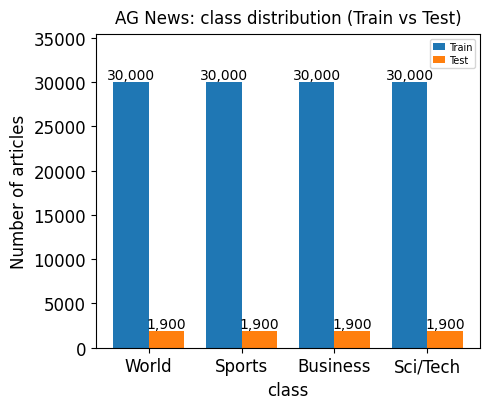

Saved figure to: agnews_class_distribution_single_col_counts.png


,label_id,label_name,train_count,test_count,train_pct,test_pct
0,0,World,30000,1900,25.0,25.0
1,1,Sports,30000,1900,25.0,25.0
2,2,Business,30000,1900,25.0,25.0
3,3,Sci/Tech,30000,1900,25.0,25.0


In [30]:
from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import DatasetDict


def plot_class_distribution(
    ds: DatasetDict,
    class_names: List[str],
    *,
    save_path: str = "agnews_class_distribution_single_col.png",
    show_percent: bool = False,
) -> pd.DataFrame:
    """
    Plot AG News class distribution (Train vs Test) in a Word 2-column friendly style.

    Changes from your version:
    - Removed the top subtitle (Train n=..., Test n=...)
    - Smaller, cleaner legend
    - Kept larger fonts + high DPI for Word
    """
    train_counts = (
        pd.Series(ds["train"]["label"])
        .value_counts()
        .sort_index()
        .reindex(range(len(class_names)), fill_value=0)
    )
    test_counts = (
        pd.Series(ds["test"]["label"])
        .value_counts()
        .sort_index()
        .reindex(range(len(class_names)), fill_value=0)
    )

    summary = pd.DataFrame(
        {
            "label_id": list(range(len(class_names))),
            "label_name": class_names,
            "train_count": train_counts.values,
            "test_count": test_counts.values,
        }
    )

    summary["train_pct"] = 100.0 * summary["train_count"] / max(
        1, summary["train_count"].sum()
    )
    summary["test_pct"] = 100.0 * summary["test_count"] / max(
        1, summary["test_count"].sum()
    )

    y_train = summary["train_pct"] if show_percent else summary["train_count"]
    y_test = summary["test_pct"] if show_percent else summary["test_count"]

    # Fonts tuned for Word 2-column insertion
    title_fs = 12
    label_fs = 12
    tick_fs = 12
    legend_fs = 7     # smaller legend
    annot_fs = 10

    fig, ax = plt.subplots(figsize=(5, 4.2))

    x = np.arange(len(class_names))
    width = 0.38

    bars_train = ax.bar(x - width / 2, y_train, width=width, label="Train")
    bars_test = ax.bar(x + width / 2, y_test, width=width, label="Test")

    unit = "Percentage of split (%)" if show_percent else "Number of articles"
    ax.set_title("AG News: class distribution (Train vs Test)", fontsize=title_fs, pad=8)
    ax.set_xlabel("class", fontsize=label_fs)
    ax.set_ylabel(unit, fontsize=label_fs)

    ax.set_xticks(x)
    ax.set_xticklabels(summary["label_name"], fontsize=tick_fs)
    ax.tick_params(axis="y", labelsize=tick_fs)

    # Annotate values on bars
    for bars in (bars_train, bars_test):
        for b in bars:
            h = float(b.get_height())
            if h <= 0:
                continue
            label = f"{h:.1f}%" if show_percent else f"{int(h):,}"
            ax.text(
                b.get_x() + b.get_width() / 2,
                h,
                label,
                ha="center",
                va="bottom",
                fontsize=annot_fs,
            )

    # Smaller legend, tucked into corner
    ax.legend(
        loc="upper right",
        fontsize=legend_fs,
        frameon=True,
        borderpad=0.3,
        labelspacing=0.3,
        handlelength=1.2,
        handletextpad=0.4,
    )

    ax.margins(y=0.18)
    fig.tight_layout()
    fig.savefig(save_path, dpi=400, bbox_inches="tight")
    plt.show()

    print(f"Saved figure to: {save_path}")
    return summary


label_summary = plot_class_distribution(
    dataset,
    label_names,
    save_path="agnews_class_distribution_single_col_counts.png",
    show_percent=False,
)
label_summary


## **Metrics (macro + accuracy)**

**Requirement:** report accuracy, precision, recall, F1.  
**Choice:** Macro averages treat each class equally.


In [5]:
def compute_macro_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    """Compute accuracy and macro-averaged precision/recall/F1."""
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
    return {
        "accuracy": float(acc),
        "macro_precision": float(prec),
        "macro_recall": float(rec),
        "macro_f1": float(f1),
    }


## **Config + reproducibility artifacts**

Saved:
- `config.json` (all key settings)
- `grid_results.csv` (hyperparameter tuning outcomes)
- `history.csv` (training curve values)
- `best_model.pt` (best checkpoint state_dict)
- `test_predictions.csv` (true/pred labels for audit)


In [6]:
@dataclass(frozen=True)
class TrainConfig:
    """Configuration for tokenization, splitting, and training."""
    model_name: str = "bert-base-uncased"
    max_length: int = 128
    val_ratio: float = 0.20
    batch_size: int = 16
    seed: int = 42
    output_dir: str = "artifacts_agnews"


CFG = TrainConfig()
os.makedirs(CFG.output_dir, exist_ok=True)

with open(os.path.join(CFG.output_dir, "config.json"), "w", encoding="utf-8") as f:
    json.dump(CFG.__dict__, f, indent=2)

num_labels = len(label_names)
print("Saved config to:", os.path.join(CFG.output_dir, "config.json"))


Saved config to: artifacts_agnews/config.json


## **Baseline: TF-IDF + Logistic Regression (test evaluation)**

**Why baseline:** classical ML reference point for the fine-tuned Transformer.  
**No leakage:** baseline trains on train split, evaluates on official test split.


Baseline (TF-IDF + Logistic Regression) — TEST:
        accuracy: 0.9213
 macro_precision: 0.9211
    macro_recall: 0.9213
        macro_f1: 0.9211

Classification report (baseline):
              precision    recall  f1-score   support

       World       0.93      0.91      0.92      1900
      Sports       0.96      0.98      0.97      1900
    Business       0.90      0.89      0.89      1900
    Sci/Tech       0.90      0.90      0.90      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600



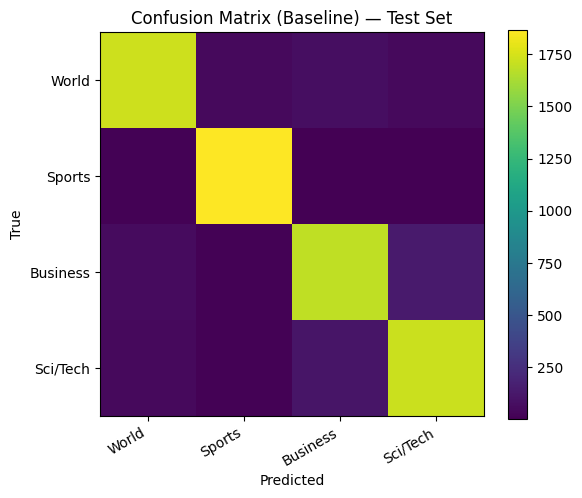

Saved: artifacts_agnews/baseline_predictions.csv


In [7]:
def run_baseline_tfidf_logreg(
    ds: DatasetDict,
    target_names: List[str],
    output_dir: str,
    show_confusion_matrix: bool = True,
) -> Dict[str, Any]:
    """
    Train TF-IDF + Logistic Regression baseline and evaluate on the official test split.

    Artifact:
        Saves baseline predictions for reproducibility/audit.
    """
    x_train = ds["train"]["text"]
    y_train = np.array(ds["train"]["label"])

    x_test = ds["test"]["text"]
    y_test = np.array(ds["test"]["label"])

    vectorizer = TfidfVectorizer(
        max_features=50_000,
        ngram_range=(1, 2),
        lowercase=True,
        stop_words="english",
    )
    x_train_vec = vectorizer.fit_transform(x_train)
    x_test_vec = vectorizer.transform(x_test)

    try:
        model = LogisticRegression(
            max_iter=200,
            solver="lbfgs",
            n_jobs=-1,
            multi_class="multinomial",
        )
    except TypeError:
        model = LogisticRegression(max_iter=200, solver="lbfgs")

    model.fit(x_train_vec, y_train)
    y_pred = model.predict(x_test_vec)

    metrics = compute_macro_metrics(y_test, y_pred)

    print("Baseline (TF-IDF + Logistic Regression) — TEST:")
    for k, v in metrics.items():
        print(f"{k:>16}: {v:.4f}")

    print("\nClassification report (baseline):")
    print(classification_report(y_test, y_pred, target_names=target_names))

    if show_confusion_matrix:
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 5))
        plt.imshow(cm)
        plt.title("Confusion Matrix (Baseline) — Test Set")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.xticks(range(len(target_names)), target_names, rotation=30, ha="right")
        plt.yticks(range(len(target_names)), target_names)
        plt.colorbar()
        plt.tight_layout()
        plt.show()

    preds_path = os.path.join(output_dir, "baseline_predictions.csv")
    pd.DataFrame({"y_true": y_test, "y_pred": y_pred}).to_csv(preds_path, index=False)
    print("Saved:", preds_path)

    return {"metrics": metrics, "y_true": y_test, "y_pred": y_pred}


baseline_output = run_baseline_tfidf_logreg(
    ds=dataset,
    target_names=label_names,
    output_dir=CFG.output_dir,
)
baseline_metrics = baseline_output["metrics"]


## **Tokenization + DataLoaders (train/val/test)**

**Requirement:** tokenize text using a BERT tokenizer.  
**No leakage:** validation is split from train; test is untouched until final evaluation.


In [8]:
TOKENIZED_CACHE: Dict[Tuple[str, int], DatasetDict] = {}


def clear_gpu_memory() -> None:
    """Free CUDA cached memory to reduce OOM risk."""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


def prepare_tokenized_splits_and_loaders(
    ds: DatasetDict,
    model_name: str,
    max_length: int,
    batch_size: int,
    val_ratio: float,
    seed: int,
) -> Tuple[DataLoader, DataLoader, DataLoader, AutoTokenizer]:
    """Tokenize dataset and create train/val/test DataLoaders."""
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    cache_key = (model_name, max_length)

    if cache_key not in TOKENIZED_CACHE:

        def _tokenize(batch: Dict[str, Any]) -> Dict[str, Any]:
            return tokenizer(batch["text"], truncation=True, max_length=max_length)

        tokenized = ds.map(_tokenize, batched=True)
        tokenized = tokenized.rename_column("label", "labels")
        tokenized = tokenized.remove_columns(["text"])
        tokenized.set_format("torch")
        TOKENIZED_CACHE[cache_key] = tokenized
        print("✅ Tokenization cached for:", cache_key)
    else:
        tokenized = TOKENIZED_CACHE[cache_key]

    split = tokenized["train"].train_test_split(test_size=val_ratio, seed=seed)
    train_ds = split["train"]
    val_ds = split["test"]
    test_ds = tokenized["test"]

    collator = DataCollatorWithPadding(tokenizer=tokenizer)

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collator,
        num_workers=2,
        pin_memory=torch.cuda.is_available(),
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collator,
        num_workers=2,
        pin_memory=torch.cuda.is_available(),
    )
    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collator,
        num_workers=2,
        pin_memory=torch.cuda.is_available(),
    )

    return train_loader, val_loader, test_loader, tokenizer


## Model Architecture and Training Pipeline (BERT Fine-tuning)

**Model chosen:** `bert-base-uncased` (BERT encoder + classification head)  
**Task:** 4-class topic classification (AG News: World, Sports, Business, Sci/Tech)

### Why BERT is appropriate for this problem
BERT is an encoder-only Transformer pretrained to learn rich contextual word representations.
For topic classification, context matters because the same token can have different meanings
depending on surrounding words (e.g., "Apple" company vs fruit). BERT’s self-attention
captures long-range dependencies and produces a strong sequence representation for classification.

### Architecture (high level)
- Input text is tokenized with **BERT WordPiece tokenizer**.
- The tokenized sequence is passed through the **BERT encoder**.
- The special token `[CLS]` represents the whole sequence.
- A **classification head** (linear layer) maps the `[CLS]` embedding to 4 output logits.
- Training minimizes **cross-entropy loss** for multi-class classification.

### Pipeline diagram

Raw text
  ↓
BERT tokenizer (WordPiece) + truncation (max_length) + dynamic padding per batch
  ↓
input_ids, attention_mask, token_type_ids
  ↓
BERT encoder (12 Transformer layers: self-attention + feed-forward)
  ↓
[CLS] pooled embedding (sequence-level representation)
  ↓
Classification head (dropout + linear layer)
  ↓
Logits for 4 classes
  ↓
CrossEntropyLoss (computed internally when labels are provided)

### Key hyperparameters (and why)
- **max_length:** controls how much context the model reads (trade-off: context vs compute)
- **batch_size:** controls gradient stability and GPU memory usage
- **learning_rate:** most sensitive fine-tuning parameter (too high can destabilize training)
- **weight_decay:** regularization to reduce overfitting
- **warmup_ratio:** stabilizes early training by slowly increasing the learning rate
- **early stopping + best checkpoint:** selects the best epoch using validation Macro-F1 and
  prevents overfitting; test set is only used once for final evaluation (no leakage)


## **Build LLM model (BERT for sequence classification)**

I use `AutoModelForSequenceClassification` which attaches a classification head on top of BERT.

**Input:** token IDs + attention mask (dynamic padding per batch).  
**Output:** logits for 4 classes and cross-entropy loss (when labels are provided).


In [9]:
def build_model(model_name: str, num_labels: int) -> torch.nn.Module:
    """Create a BERT-style sequence classification model with `num_labels` outputs."""
    return AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
    )


## **Evaluation (validation/test)**

**Requirement:** report accuracy, precision, recall, F1.  
I compute:
- Weighted-average loss (correct even if last batch is smaller)
- Macro metrics from predictions

**No leakage:** validation is used for model selection; test is used once at the end.


In [10]:
@torch.no_grad()
def evaluate_model(model: torch.nn.Module, dataloader: DataLoader) -> Dict[str, Any]:
    """Evaluate model and return weighted average loss + macro metrics + predictions."""
    model.eval()

    total_loss = 0.0
    total_examples = 0
    preds_list: List[np.ndarray] = []
    labels_list: List[np.ndarray] = []

    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        batch_size = int(batch["labels"].size(0))

        outputs = model(**batch)
        loss = outputs.loss

        total_loss += float(loss.item()) * batch_size
        total_examples += batch_size

        preds = torch.argmax(outputs.logits, dim=-1)
        preds_list.append(preds.detach().cpu().numpy())
        labels_list.append(batch["labels"].detach().cpu().numpy())

    y_pred = np.concatenate(preds_list)
    y_true = np.concatenate(labels_list)

    metrics = compute_macro_metrics(y_true, y_pred)
    avg_loss = total_loss / max(1, total_examples)

    return {"loss": avg_loss, "metrics": metrics, "y_true": y_true, "y_pred": y_pred}


## **Training loop**

I fine-tune all model parameters using:
- AdamW optimizer
- Linear LR schedule with warmup
- Gradient clipping for stability


In [11]:
def train_one_epoch(
    model: torch.nn.Module,
    dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    scheduler: Optional[Any] = None,
    grad_clip_norm: float = 1.0,
    use_amp: bool = True,
    grad_accum_steps: int = 1,
) -> float:
    """
    Train for one epoch and return weighted average training loss.

    Notes:
    - Uses mixed precision (AMP) on CUDA to speed up training and reduce memory.
    - Uses gradient accumulation to simulate larger effective batch sizes.
    - Hugging Face computes CrossEntropyLoss internally when `labels` are present.
    """
    model.train()

    if grad_accum_steps < 1:
        raise ValueError("grad_accum_steps must be >= 1.")

    use_cuda = torch.cuda.is_available()
    amp_enabled = bool(use_amp and use_cuda)

    # New AMP API (avoids FutureWarning)
    scaler = torch.amp.GradScaler("cuda", enabled=amp_enabled)

    total_loss = 0.0
    total_examples = 0

    optimizer.zero_grad(set_to_none=True)

    for step, batch in enumerate(dataloader, start=1):
        batch = {k: v.to(device) for k, v in batch.items()}
        batch_size = int(batch["labels"].size(0))

        # Forward pass under autocast
        with torch.amp.autocast("cuda", enabled=amp_enabled):
            outputs = model(**batch)
            loss = outputs.loss / grad_accum_steps

        # Backward (scaled if AMP enabled)
        scaler.scale(loss).backward()

        # Step optimizer every grad_accum_steps
        if step % grad_accum_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip_norm)

            scaler.step(optimizer)
            scaler.update()

            if scheduler is not None:
                scheduler.step()

            optimizer.zero_grad(set_to_none=True)

        # Track true (non-divided) loss for reporting
        total_loss += float(loss.item()) * batch_size * grad_accum_steps
        total_examples += batch_size

    # Handle leftover grads if steps not divisible by grad_accum_steps
    if len(dataloader) % grad_accum_steps != 0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip_norm)

        scaler.step(optimizer)
        scaler.update()

        if scheduler is not None:
            scheduler.step()

        optimizer.zero_grad(set_to_none=True)

    return total_loss / max(1, total_examples)


## **Train with early stopping (selection on validation macro-F1)**

**Model selection rule:** keep the checkpoint with the best validation Macro-F1.

**Early stopping:** stop if Macro-F1 does not improve for `patience` epochs.

**No leakage:** test set is not used here.


In [12]:
def train_with_early_stop_and_best_ckpt(
    model_name: str,
    num_labels: int,
    train_loader: DataLoader,
    val_loader: DataLoader,
    lr: float,
    epochs: int,
    weight_decay: float,
    warmup_ratio: float,
    patience: int,
    grad_clip_norm: float,
    seed: int,
    use_amp: bool = True,
    grad_accum_steps: int = 1,
) -> Tuple[float, Dict[str, torch.Tensor]]:
    """
    Train and early-stop using VAL macro-F1.

    Returns:
        best_val_macro_f1, best_checkpoint_state_dict (CPU)
    """
    set_seed(seed)
    model = build_model(model_name, num_labels).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # ✅ Correct scheduler step count when using gradient accumulation
    steps_per_epoch = (len(train_loader) + grad_accum_steps - 1) // max(1, grad_accum_steps)
    total_steps = steps_per_epoch * epochs
    warmup_steps = int(warmup_ratio * total_steps)

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps,
    )

    best_val_f1 = -1.0
    best_state_dict: Optional[Dict[str, torch.Tensor]] = None
    no_improve = 0

    for epoch in range(1, epochs + 1):
        train_loss = train_one_epoch(
            model=model,
            dataloader=train_loader,
            optimizer=optimizer,
            scheduler=scheduler,
            grad_clip_norm=grad_clip_norm,
            use_amp=use_amp,
            grad_accum_steps=grad_accum_steps,
        )

        val_out = evaluate_model(model, val_loader)
        val_loss = float(val_out["loss"])
        val_f1 = float(val_out["metrics"]["macro_f1"])

        print(
            f"Epoch {epoch}/{epochs} | "
            f"train_loss={train_loss:.4f} val_loss={val_loss:.4f} "
            f"val_macro_f1={val_f1:.4f}"
        )

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state_dict = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1

        if no_improve >= patience:
            print("Early stopping triggered (no improvement on val Macro-F1).")
            break

    if best_state_dict is None:
        best_state_dict = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    return best_val_f1, best_state_dict


## **Grid search (validation-only selection) + save results**

We run a small hyperparameter grid due to compute limits and time saving.

**Saved artifact:** `grid_results.csv` in `CFG.output_dir`.


In [14]:
set_seed(CFG.seed)
clear_gpu_memory()

learning_rates = [2e-5, 3e-5]
batch_sizes = [16, 32]
epochs_to_try = [3, 4]
weight_decays = [0.0, 0.01]

warmup_ratio = 0.10
grad_clip_norm = 1.0
patience = 2

# Speed knobs (recommended for your slow training)
use_amp = True
grad_accum_steps = 1  # set to 2 if you must use batch_size=16 but want stability

results: List[Dict[str, float]] = []
best_config: Optional[Dict[str, float]] = None
best_val_f1_overall = -1.0

print("Starting grid search (selection on VAL only)...")

for lr, bs, ep, wd in product(learning_rates, batch_sizes, epochs_to_try, weight_decays):
    print("\n-------------------------")
    print(f"Config: lr={lr}, bs={bs}, epochs={ep}, weight_decay={wd}")
    print("-------------------------")

    try:
        clear_gpu_memory()

        train_loader, val_loader, _, _ = prepare_tokenized_splits_and_loaders(
            ds=dataset,
            model_name=CFG.model_name,
            max_length=CFG.max_length,
            batch_size=bs,
            val_ratio=CFG.val_ratio,
            seed=CFG.seed,
        )

        val_f1, _ = train_with_early_stop_and_best_ckpt(
            model_name=CFG.model_name,
            num_labels=num_labels,
            train_loader=train_loader,
            val_loader=val_loader,
            lr=float(lr),
            epochs=int(ep),
            weight_decay=float(wd),
            warmup_ratio=float(warmup_ratio),
            patience=int(patience),
            grad_clip_norm=float(grad_clip_norm),
            seed=CFG.seed,
            use_amp=use_amp,
            grad_accum_steps=grad_accum_steps,
        )

    except RuntimeError as err:
        if "out of memory" in str(err).lower():
            print("Skipped: CUDA OOM")
            clear_gpu_memory()
            continue
        raise

    row = {
        "lr": float(lr),
        "batch_size": float(bs),
        "epochs": float(ep),
        "weight_decay": float(wd),
        "best_val_macro_f1": float(val_f1),
    }
    results.append(row)

    if val_f1 > best_val_f1_overall:
        best_val_f1_overall = float(val_f1)
        best_config = {
            "lr": float(lr),
            "batch_size": float(bs),
            "epochs": float(ep),
            "weight_decay": float(wd),
        }

results_df = pd.DataFrame(results).sort_values("best_val_macro_f1", ascending=False)

print("\n✅ Best config (VAL Macro-F1):", best_config)
print("Best VAL Macro-F1:", best_val_f1_overall)

grid_path = os.path.join(CFG.output_dir, "grid_results.csv")
results_df.to_csv(grid_path, index=False)
print("Saved:", grid_path)

results_df


Starting grid search (selection on VAL only)...

-------------------------
Config: lr=2e-05, bs=16, epochs=3, weight_decay=0.0
-------------------------


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | train_loss=0.2932 val_loss=0.2153 val_macro_f1=0.9396
Epoch 2/3 | train_loss=0.1478 val_loss=0.1808 val_macro_f1=0.9492
Epoch 3/3 | train_loss=0.0896 val_loss=0.2143 val_macro_f1=0.9489

-------------------------
Config: lr=2e-05, bs=16, epochs=3, weight_decay=0.01
-------------------------


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | train_loss=0.2933 val_loss=0.2172 val_macro_f1=0.9381
Epoch 2/3 | train_loss=0.1476 val_loss=0.1792 val_macro_f1=0.9481
Epoch 3/3 | train_loss=0.0900 val_loss=0.2147 val_macro_f1=0.9479

-------------------------
Config: lr=2e-05, bs=16, epochs=4, weight_decay=0.0
-------------------------


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4 | train_loss=0.3052 val_loss=0.2155 val_macro_f1=0.9378
Epoch 2/4 | train_loss=0.1559 val_loss=0.1857 val_macro_f1=0.9458
Epoch 3/4 | train_loss=0.0976 val_loss=0.2250 val_macro_f1=0.9454
Epoch 4/4 | train_loss=0.0569 val_loss=0.2691 val_macro_f1=0.9468

-------------------------
Config: lr=2e-05, bs=16, epochs=4, weight_decay=0.01
-------------------------


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4 | train_loss=0.3053 val_loss=0.2249 val_macro_f1=0.9379
Epoch 2/4 | train_loss=0.1561 val_loss=0.1791 val_macro_f1=0.9478
Epoch 3/4 | train_loss=0.0978 val_loss=0.2281 val_macro_f1=0.9460
Epoch 4/4 | train_loss=0.0573 val_loss=0.2730 val_macro_f1=0.9472
Early stopping triggered (no improvement on val Macro-F1).

-------------------------
Config: lr=2e-05, bs=32, epochs=3, weight_decay=0.0
-------------------------


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | train_loss=0.2988 val_loss=0.1909 val_macro_f1=0.9393
Epoch 2/3 | train_loss=0.1381 val_loss=0.1642 val_macro_f1=0.9479
Epoch 3/3 | train_loss=0.0873 val_loss=0.1810 val_macro_f1=0.9482

-------------------------
Config: lr=2e-05, bs=32, epochs=3, weight_decay=0.01
-------------------------


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | train_loss=0.2989 val_loss=0.1902 val_macro_f1=0.9395
Epoch 2/3 | train_loss=0.1375 val_loss=0.1651 val_macro_f1=0.9476
Epoch 3/3 | train_loss=0.0873 val_loss=0.1793 val_macro_f1=0.9482

-------------------------
Config: lr=2e-05, bs=32, epochs=4, weight_decay=0.0
-------------------------


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4 | train_loss=0.3135 val_loss=0.1925 val_macro_f1=0.9389
Epoch 2/4 | train_loss=0.1440 val_loss=0.1655 val_macro_f1=0.9480
Epoch 3/4 | train_loss=0.0923 val_loss=0.1919 val_macro_f1=0.9466
Epoch 4/4 | train_loss=0.0584 val_loss=0.2253 val_macro_f1=0.9462
Early stopping triggered (no improvement on val Macro-F1).

-------------------------
Config: lr=2e-05, bs=32, epochs=4, weight_decay=0.01
-------------------------


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4 | train_loss=0.3126 val_loss=0.1955 val_macro_f1=0.9375
Epoch 2/4 | train_loss=0.1434 val_loss=0.1648 val_macro_f1=0.9484
Epoch 3/4 | train_loss=0.0912 val_loss=0.1900 val_macro_f1=0.9462
Epoch 4/4 | train_loss=0.0577 val_loss=0.2232 val_macro_f1=0.9472
Early stopping triggered (no improvement on val Macro-F1).

-------------------------
Config: lr=3e-05, bs=16, epochs=3, weight_decay=0.0
-------------------------


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | train_loss=0.2868 val_loss=0.2199 val_macro_f1=0.9398
Epoch 2/3 | train_loss=0.1492 val_loss=0.1890 val_macro_f1=0.9482
Epoch 3/3 | train_loss=0.0862 val_loss=0.2177 val_macro_f1=0.9490

-------------------------
Config: lr=3e-05, bs=16, epochs=3, weight_decay=0.01
-------------------------


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | train_loss=0.2875 val_loss=0.2131 val_macro_f1=0.9398
Epoch 2/3 | train_loss=0.1472 val_loss=0.1815 val_macro_f1=0.9483
Epoch 3/3 | train_loss=0.0844 val_loss=0.2187 val_macro_f1=0.9487

-------------------------
Config: lr=3e-05, bs=16, epochs=4, weight_decay=0.0
-------------------------


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4 | train_loss=0.2963 val_loss=0.2285 val_macro_f1=0.9372
Epoch 2/4 | train_loss=0.1576 val_loss=0.1758 val_macro_f1=0.9484
Epoch 3/4 | train_loss=0.0966 val_loss=0.2331 val_macro_f1=0.9464
Epoch 4/4 | train_loss=0.0530 val_loss=0.2787 val_macro_f1=0.9464
Early stopping triggered (no improvement on val Macro-F1).

-------------------------
Config: lr=3e-05, bs=16, epochs=4, weight_decay=0.01
-------------------------


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4 | train_loss=0.2965 val_loss=0.2207 val_macro_f1=0.9372
Epoch 2/4 | train_loss=0.1576 val_loss=0.1844 val_macro_f1=0.9472
Epoch 3/4 | train_loss=0.0977 val_loss=0.2270 val_macro_f1=0.9472
Epoch 4/4 | train_loss=0.0527 val_loss=0.2723 val_macro_f1=0.9469

-------------------------
Config: lr=3e-05, bs=32, epochs=3, weight_decay=0.0
-------------------------


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | train_loss=0.2864 val_loss=0.2009 val_macro_f1=0.9362
Epoch 2/3 | train_loss=0.1341 val_loss=0.1692 val_macro_f1=0.9483
Epoch 3/3 | train_loss=0.0776 val_loss=0.1877 val_macro_f1=0.9498

-------------------------
Config: lr=3e-05, bs=32, epochs=3, weight_decay=0.01
-------------------------


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | train_loss=0.2865 val_loss=0.1973 val_macro_f1=0.9362
Epoch 2/3 | train_loss=0.1349 val_loss=0.1642 val_macro_f1=0.9495
Epoch 3/3 | train_loss=0.0780 val_loss=0.1864 val_macro_f1=0.9498

-------------------------
Config: lr=3e-05, bs=32, epochs=4, weight_decay=0.0
-------------------------


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4 | train_loss=0.2996 val_loss=0.1910 val_macro_f1=0.9404
Epoch 2/4 | train_loss=0.1413 val_loss=0.1710 val_macro_f1=0.9474
Epoch 3/4 | train_loss=0.0842 val_loss=0.2001 val_macro_f1=0.9454
Epoch 4/4 | train_loss=0.0473 val_loss=0.2398 val_macro_f1=0.9474

-------------------------
Config: lr=3e-05, bs=32, epochs=4, weight_decay=0.01
-------------------------


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4 | train_loss=0.2983 val_loss=0.1863 val_macro_f1=0.9393
Epoch 2/4 | train_loss=0.1408 val_loss=0.1659 val_macro_f1=0.9465
Epoch 3/4 | train_loss=0.0846 val_loss=0.1996 val_macro_f1=0.9463
Epoch 4/4 | train_loss=0.0466 val_loss=0.2374 val_macro_f1=0.9474

✅ Best config (VAL Macro-F1): {'lr': 3e-05, 'batch_size': 32.0, 'epochs': 3.0, 'weight_decay': 0.01}
Best VAL Macro-F1: 0.9498225815984851
Saved: artifacts_agnews/grid_results.csv


,lr,batch_size,epochs,weight_decay,best_val_macro_f1
13,0.00003,32.0,3.0,0.01,0.949823
12,0.00003,32.0,3.0,0.00,0.949760
0,0.00002,16.0,3.0,0.00,0.949243
8,0.00003,16.0,3.0,0.00,0.948974
9,0.00003,16.0,3.0,0.01,0.948651
7,0.00002,32.0,4.0,0.01,0.948405
10,0.00003,16.0,4.0,0.00,0.948351
4,0.00002,32.0,3.0,0.00,0.948235
5,0.00002,32.0,3.0,0.01,0.948195
1,0.00002,16.0,3.0,0.01,0.948140


## **Retrain best config once + save history + save best checkpoint**

We retrain using the best hyperparameters and record:
- train loss
- validation loss
- validation Macro-F1

**Saved artifacts:**
- `history.csv`
- `best_model.pt`


In [15]:
def train_bert_with_history(
    model_name: str,
    num_labels: int,
    train_loader: DataLoader,
    val_loader: DataLoader,
    learning_rate: float,
    epochs: int,
    weight_decay: float,
    warmup_ratio: float,
    patience: int,
    grad_clip_norm: float,
    seed: int,
    grad_accum_steps: int = 1,
    use_amp: bool = True,
) -> Tuple[Dict[str, torch.Tensor], pd.DataFrame, Dict[str, Any]]:
    """Train model, log history, and return best checkpoint based on val macro-F1."""
    set_seed(seed)
    model = build_model(model_name, num_labels).to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay
    )

    # Correct scheduler step count when using gradient accumulation
    steps_per_epoch = (len(train_loader) + grad_accum_steps - 1) // grad_accum_steps
    total_steps = steps_per_epoch * epochs
    warmup_steps = int(warmup_ratio * total_steps)

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps,
    )

    history: List[Dict[str, float]] = []
    best_val_f1 = -1.0
    best_epoch = 0
    best_state_dict: Optional[Dict[str, torch.Tensor]] = None
    no_improve = 0

    for epoch in range(1, epochs + 1):
        train_loss = train_one_epoch(
            model=model,
            dataloader=train_loader,
            optimizer=optimizer,
            scheduler=scheduler,
            grad_clip_norm=grad_clip_norm,
            grad_accum_steps=grad_accum_steps,
            use_amp=use_amp,
        )

        val_out = evaluate_model(model, val_loader)
        val_loss = float(val_out["loss"])
        val_f1 = float(val_out["metrics"]["macro_f1"])

        history.append(
            {
                "epoch": float(epoch),
                "train_loss": float(train_loss),
                "val_loss": float(val_loss),
                "val_macro_f1": float(val_f1),
            }
        )

        print(
            f"Epoch {epoch}/{epochs} | "
            f"train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_macro_f1={val_f1:.4f}"
        )

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_epoch = epoch
            best_state_dict = {
                k: v.detach().cpu().clone() for k, v in model.state_dict().items()
            }
            no_improve = 0
        else:
            no_improve += 1

        if no_improve >= patience:
            print("Early stopping triggered (no improvement on val Macro-F1).")
            break

    if best_state_dict is None:
        best_state_dict = {
            k: v.detach().cpu().clone() for k, v in model.state_dict().items()
        }

    history_df = pd.DataFrame(history)
    best_info = {"best_epoch": int(best_epoch), "best_val_macro_f1": float(best_val_f1)}

    return best_state_dict, history_df, best_info


# ----------------------------
# Retrain best config + save
# ----------------------------
if best_config is None:
    raise ValueError("Grid search found no valid config (maybe all OOM).")

best_lr = float(best_config["lr"])
best_bs = int(best_config["batch_size"])
best_epochs = int(best_config["epochs"])
best_wd = float(best_config["weight_decay"])

clear_gpu_memory()

train_loader, val_loader, test_loader, _ = prepare_tokenized_splits_and_loaders(
    ds=dataset,
    model_name=CFG.model_name,
    max_length=CFG.max_length,
    batch_size=best_bs,
    val_ratio=CFG.val_ratio,
    seed=CFG.seed,
)

best_state_dict, history_df, best_info = train_bert_with_history(
    model_name=CFG.model_name,
    num_labels=num_labels,
    train_loader=train_loader,
    val_loader=val_loader,
    learning_rate=best_lr,
    epochs=best_epochs,
    weight_decay=best_wd,
    warmup_ratio=warmup_ratio,
    patience=patience,
    grad_clip_norm=grad_clip_norm,
    seed=CFG.seed,
    grad_accum_steps=grad_accum_steps,  # uses your global setting (usually 1)
    use_amp=use_amp,                    # uses your global setting (usually True)
)

print("\nBest epoch:", best_info["best_epoch"])
print("Best VAL Macro-F1:", best_info["best_val_macro_f1"])

history_path = os.path.join(CFG.output_dir, "history.csv")
history_df.to_csv(history_path, index=False)
print("Saved:", history_path)

best_model_path = os.path.join(CFG.output_dir, "best_model.pt")
torch.save(best_state_dict, best_model_path)
print("Saved:", best_model_path)

history_df


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | train_loss=0.2865 val_loss=0.1973 val_macro_f1=0.9362
Epoch 2/3 | train_loss=0.1349 val_loss=0.1642 val_macro_f1=0.9495
Epoch 3/3 | train_loss=0.0780 val_loss=0.1864 val_macro_f1=0.9498

Best epoch: 3
Best VAL Macro-F1: 0.9498225815984851
Saved: artifacts_agnews/history.csv
Saved: artifacts_agnews/best_model.pt


,epoch,train_loss,val_loss,val_macro_f1
0,1.0,0.286478,0.197278,0.936193
1,2.0,0.134913,0.164185,0.949464
2,3.0,0.078033,0.186352,0.949823


## **Plot training curves**

We plot:
- Train vs validation loss
- Validation Macro-F1 across epochs


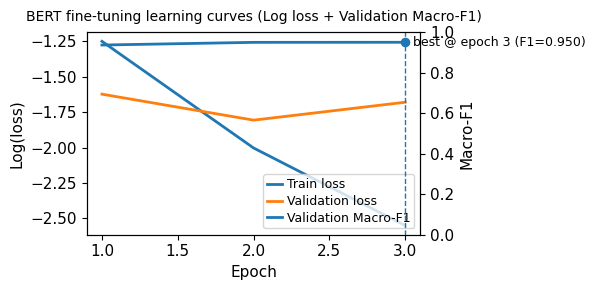

Saved figure to: bert_training_curves_one_figure.png


In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_training_curves_one_figure(
    history: pd.DataFrame,
    *,
    use_log_loss: bool = True,
    save_path: str = "bert_training_curves_one_figure.png",
) -> None:
    """
    One-figure training curves for reports

    What it shows (self-explanatory):
    - Train vs Val loss (optionally Log(loss)) on left y-axis
    - Validation Macro-F1 on right y-axis
    - Best epoch marker (highest val_macro_f1)
    - Compact legend, readable fonts, high-DPI export
    """
    required_cols = {"epoch", "train_loss", "val_loss", "val_macro_f1"}
    missing = required_cols - set(history.columns)
    if missing:
        raise ValueError(f"history is missing columns: {sorted(missing)}")

    df = history.copy()
    df = df.sort_values("epoch")

    train_loss = df["train_loss"].astype(float).to_numpy()
    val_loss = df["val_loss"].astype(float).to_numpy()
    val_f1 = df["val_macro_f1"].astype(float).to_numpy()
    epochs = df["epoch"].astype(int).to_numpy()

    if use_log_loss:
        y_train = np.log(np.maximum(train_loss, 1e-12))
        y_val = np.log(np.maximum(val_loss, 1e-12))
        loss_ylabel = "Log(loss)"
        title = "BERT fine-tuning learning curves (Log loss + Validation Macro-F1)"
    else:
        y_train = train_loss
        y_val = val_loss
        loss_ylabel = "Loss"
        title = "BERT fine-tuning learning curves (Loss + Validation Macro-F1)"

    best_idx = int(np.argmax(val_f1))
    best_epoch = int(epochs[best_idx])
    best_f1 = float(val_f1[best_idx])

    # Word 2-column friendly size + readable fonts
    title_fs = 10
    label_fs = 11
    tick_fs = 11
    legend_fs = 9
    annot_fs = 9

    fig, ax1 = plt.subplots(figsize=(6, 3))

    # Loss curves on left axis
    l1 = ax1.plot(epochs, y_train, label="Train loss", linewidth=2)
    l2 = ax1.plot(epochs, y_val, label="Validation loss", linewidth=2)

    ax1.set_title(title, fontsize=title_fs, pad=8)
    ax1.set_xlabel("Epoch", fontsize=label_fs)
    ax1.set_ylabel(loss_ylabel, fontsize=label_fs)
    ax1.tick_params(axis="both", labelsize=tick_fs)

    # F1 curve on right axis
    ax2 = ax1.twinx()
    l3 = ax2.plot(epochs, val_f1, label="Validation Macro-F1", linewidth=2)
    ax2.set_ylabel("Macro-F1", fontsize=label_fs)
    ax2.tick_params(axis="y", labelsize=tick_fs)
    ax2.set_ylim(0.0, 1.0)

    # Best epoch marker (clear and report-friendly)
    ax2.axvline(best_epoch, linestyle="--", linewidth=1)
    ax2.scatter([best_epoch], [best_f1], s=35)
    ax2.text(
        best_epoch,
        best_f1,
        f"  best @ epoch {best_epoch} (F1={best_f1:.3f})",
        fontsize=annot_fs,
        va="center",
    )

    # Compact legend combining both axes
    lines = l1 + l2 + l3
    labels = [ln.get_label() for ln in lines]
    ax1.legend(
        lines,
        labels,
        loc="lower right",
        fontsize=legend_fs,
        frameon=True,
        borderpad=0.3,
        labelspacing=0.3,
        handlelength=1.2,
        handletextpad=0.4,
    )

    fig.tight_layout()
    fig.savefig(save_path, dpi=400, bbox_inches="tight")
    plt.show()
    print(f"Saved figure to: {save_path}")


# Use ONE call only (recommended in the report)
plot_training_curves_one_figure(history_df, use_log_loss=True)


## **Final evaluation on official TEST set (used once)**

**Important:** The test set is used only here, after selecting the model on validation and save `test_predictions.csv` for reproducibility/audit.


In [17]:
def final_test_evaluation_and_save_predictions(
    model_name: str,
    num_labels: int,
    best_state_dict: Dict[str, torch.Tensor],
    test_loader: DataLoader,
    label_names: List[str],
    output_dir: str,
) -> Tuple[float, Dict[str, float], np.ndarray, np.ndarray]:
    """
    Evaluate the selected best checkpoint on the official TEST set once and save predictions.

    Returns:
        test_loss: Weighted average test loss.
        test_metrics: Dict with accuracy + macro precision/recall/F1.
        y_true: True labels.
        y_pred: Predicted labels.
    """
    model = build_model(model_name, num_labels).to(device)
    model.load_state_dict(best_state_dict)

    test_out = evaluate_model(model, test_loader)
    test_loss = float(test_out["loss"])
    test_metrics = test_out["metrics"]
    y_true = test_out["y_true"]
    y_pred = test_out["y_pred"]

    print("FINAL BERT results (OFFICIAL TEST) — used once:")
    print(f"{'test_loss':>16}: {test_loss:.4f}")
    for k, v in test_metrics.items():
        print(f"{k:>16}: {float(v):.4f}")

    print("\nClassification report (BERT):")
    print(classification_report(y_true, y_pred, target_names=label_names))

    preds_path = os.path.join(output_dir, "test_predictions.csv")
    pd.DataFrame({"y_true": y_true, "y_pred": y_pred}).to_csv(preds_path, index=False)
    print("Saved:", preds_path)

    return test_loss, test_metrics, y_true, y_pred


### **Call the Function**

In [18]:
test_loss, test_metrics, y_true, y_pred = final_test_evaluation_and_save_predictions(
    model_name=CFG.model_name,
    num_labels=num_labels,
    best_state_dict=best_state_dict,
    test_loader=test_loader,
    label_names=label_names,
    output_dir=CFG.output_dir,
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FINAL BERT results (OFFICIAL TEST) — used once:
       test_loss: 0.1947
        accuracy: 0.9492
 macro_precision: 0.9493
    macro_recall: 0.9492
        macro_f1: 0.9492

Classification report (BERT):
              precision    recall  f1-score   support

       World       0.96      0.96      0.96      1900
      Sports       0.99      0.99      0.99      1900
    Business       0.93      0.92      0.92      1900
    Sci/Tech       0.92      0.93      0.93      1900

    accuracy                           0.95      7600
   macro avg       0.95      0.95      0.95      7600
weighted avg       0.95      0.95      0.95      7600

Saved: artifacts_agnews/test_predictions.csv


## **Confusion matrix (BERT)**

This visualizes which classes are most commonly confused on the official test set.


In [50]:
def plot_confusion_matrix(
    y_true_arr: np.ndarray,
    y_pred_arr: np.ndarray,
    class_names: List[str],
    title: str,
) -> np.ndarray:
    """
    Plot and return the confusion matrix.

    Returns:
        cm: Confusion matrix array of shape (num_classes, num_classes).
    """
    cm = confusion_matrix(y_true_arr, y_pred_arr)

    plt.figure(figsize=(6, 4))
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(range(len(class_names)), class_names, rotation=30, ha="right")
    plt.yticks(range(len(class_names)), class_names)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    return cm


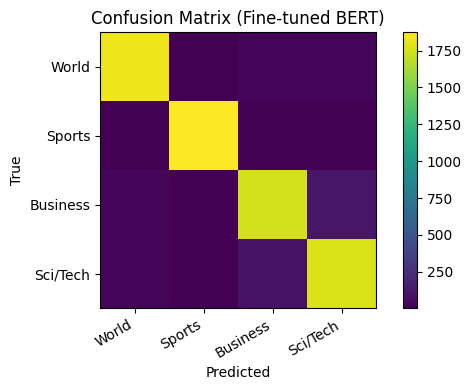

array([[1824,    8,   35,   33],
       [  10, 1874,    9,    7],
       [  35,    4, 1746,  115],
       [  29,    6,   95, 1770]])

In [52]:
cm_bert = plot_confusion_matrix(
    y_true_arr=y_true,
    y_pred_arr=y_pred,
    class_names=label_names,
    title="Confusion Matrix (Fine-tuned BERT)",
)

cm_bert


## **Baseline vs Fine-tuned BERT comparison**

We compare Macro-F1 and accuracy between:
- TF-IDF + Logistic Regression baseline
- Fine-tuned BERT (selected on validation Macro-F1)


In [22]:
def build_comparison_table(
    baseline_metrics: Dict[str, float],
    bert_metrics: Dict[str, float],
) -> pd.DataFrame:
    """
    Create a comparison table for baseline vs BERT using key metrics.

    Returns:
        comparison_df: DataFrame sorted by macro_f1 descending.
    """
    comparison_df = pd.DataFrame(
        [
            {
                "model": "Baseline (TF-IDF + Logistic Regression)",
                **baseline_metrics,
            },
            {
                "model": "Fine-tuned BERT (selected by VAL Macro-F1)",
                **bert_metrics,
            },
        ]
    ).sort_values("macro_f1", ascending=False)

    return comparison_df


comparison_df = build_comparison_table(
    baseline_metrics=baseline_metrics,
    bert_metrics=test_metrics,
)

comparison_path = os.path.join(CFG.output_dir, "comparison.csv")
comparison_df.to_csv(comparison_path, index=False)
print("Saved:", comparison_path)

comparison_df


Saved: artifacts_agnews/comparison.csv


,model,accuracy,macro_precision,macro_recall,macro_f1
1,Fine-tuned BERT (selected by VAL Macro-F1),0.949211,0.949310,0.949211,0.949245
0,Baseline (TF-IDF + Logistic Regression),0.921316,0.921137,0.921316,0.921137


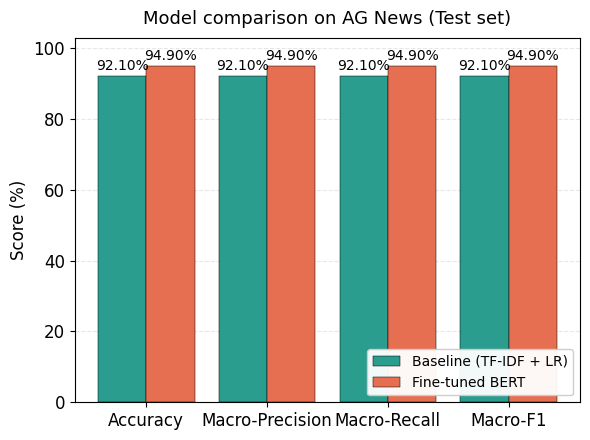

Saved figure to: artifacts_agnews/model_comparison_bar_percent.png


In [68]:
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_model_comparison_bars_aesthetic(
    baseline_metrics: dict,
    bert_metrics: dict,
    *,
    title: str = "Model comparison on AG News (Test set)",
    save_path: str = "model_comparison_bar_percent.png",
    figsize=(6, 4.5),
    dpi: int = 400,
    as_percent: bool = True
) -> None:
    metrics_order = ["accuracy", "macro_precision", "macro_recall", "macro_f1"]
    metric_labels = ["Accuracy", "Macro-Precision", "Macro-Recall", "Macro-F1"]

    baseline_vals = np.array([float(baseline_metrics[m]) for m in metrics_order])
    bert_vals = np.array([float(bert_metrics[m]) for m in metrics_order])

    if as_percent:
        baseline_plot = baseline_vals * 100
        bert_plot = bert_vals * 100
        y_label = "Score (%)"

        # ✅ Add headroom so % labels don’t touch the top border
        ymax = max(baseline_plot.max(), bert_plot.max())
        ax_top = min(120, ymax + 8)   # usually gives nice space (e.g., 94.9 -> 105.9)
        y_lim = (0, ax_top)
    else:
        baseline_plot = baseline_vals
        bert_plot = bert_vals
        y_label = "Score"
        y_lim = (0, 1.05)

    x = np.arange(len(metrics_order))
    width = 0.40

    baseline_color = "#2A9D8F"  # teal
    bert_color = "#E76F51"      # coral

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_axisbelow(True)
    ax.grid(axis="y", linestyle="--", linewidth=0.8, alpha=0.30)

    bars1 = ax.bar(x - width/2, baseline_plot, width, label="Baseline (TF-IDF + LR)",
                   color=baseline_color, edgecolor="black", linewidth=0.35)
    bars2 = ax.bar(x + width/2, bert_plot, width, label="Fine-tuned BERT",
                   color=bert_color, edgecolor="black", linewidth=0.35)

    ax.set_title(title, fontsize=13, pad=10)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(metric_labels, fontsize=12)
    ax.tick_params(axis="y", labelsize=12)
    ax.set_ylim(*y_lim)

    # ✅ Slightly smaller offset + enough space above
    def annotate(bars):
      for b in bars:
        h = float(b.get_height())

        if as_percent:
            # ✅ show rounded-to-1dp (94.9 → 95.0 if actual is 94.95+)
            text = f"{round(h, 1):.2f}%"
            offset = 0.8
        else:
            text = f"{h:.2f}"
            offset = 0.2

        ax.text(
            b.get_x() + b.get_width()/2,
            h + offset,
            text,
            ha="center",
            va="bottom",
            fontsize=10
        )
    annotate(bars1)
    annotate(bars2)

    ax.legend(fontsize=10, frameon=True, framealpha=0.95, loc="lower right")
    fig.tight_layout()
    fig.savefig(save_path, dpi=dpi, bbox_inches="tight")
    plt.show()
    print("Saved figure to:", save_path)


# Usage:
plot_model_comparison_bars_aesthetic(
    baseline_metrics=baseline_metrics,
    bert_metrics=test_metrics,
    as_percent=True,
    save_path=os.path.join(CFG.output_dir, "model_comparison_bar_percent.png"),
)


## **Error analysis (misclassified examples)**

To support interpretation, we inspect misclassified samples:
- shows the text snippet
- true label vs predicted label

This helps discuss limitations and future improvements in the report.


In [23]:
def get_misclassified_examples(
    ds_test,
    y_true_arr: np.ndarray,
    y_pred_arr: np.ndarray,
    label_names: List[str],
    max_examples: int = 20,
    text_chars: int = 200,
) -> pd.DataFrame:
    """
    Build a table of misclassified test examples.

    Args:
        ds_test: Raw test split containing "text".
        y_true_arr: True label IDs.
        y_pred_arr: Pred label IDs.
        label_names: Mapping from label ID to label string.
        max_examples: Max number of misclassified rows to return.
        text_chars: Number of text characters to show for each example.

    Returns:
        DataFrame with misclassified samples (index, true/pred labels, text snippet).
    """
    wrong_idx = np.where(y_true_arr != y_pred_arr)[0]
    wrong_idx = wrong_idx[:max_examples]

    rows: List[Dict[str, Any]] = []
    for i in wrong_idx:
        text = ds_test[int(i)]["text"]
        rows.append(
            {
                "test_index": int(i),
                "true_id": int(y_true_arr[i]),
                "true_label": label_names[int(y_true_arr[i])],
                "pred_id": int(y_pred_arr[i]),
                "pred_label": label_names[int(y_pred_arr[i])],
                "text_snippet": text[:text_chars].replace("\n", " "),
            }
        )

    return pd.DataFrame(rows)


In [24]:
misclassified_df = get_misclassified_examples(
    ds_test=dataset["test"],
    y_true_arr=y_true,
    y_pred_arr=y_pred,
    label_names=label_names,
    max_examples=20,
    text_chars=250,
)

misclassified_df


,test_index,true_id,true_label,pred_id,pred_label,text_snippet
0,20,3,Sci/Tech,2,Business,IBM to hire even more new workers By the end o...
1,23,3,Sci/Tech,2,Business,Some People Not Eligible to Get in on Google I...
2,26,1,Sports,0,World,Giddy Phelps Touches Gold for First Time Micha...
3,36,0,World,2,Business,Venezuela Prepares for Chavez Recall Vote Supp...
4,55,3,Sci/Tech,2,Business,Promoting a Shared Vision As Michael Kaleko ke...
5,83,2,Business,3,Sci/Tech,Intel to delay product aimed for high-definiti...
6,111,3,Sci/Tech,2,Business,IBM Buys Two Danish Services Firms IBM said Tu...
7,120,0,World,2,Business,Oil prices bubble to record high The price of ...
8,173,3,Sci/Tech,2,Business,Small computers can have multiple personalitie...
9,202,3,Sci/Tech,0,World,Stunt pilots to save sun dust IT PROMISES to b...


In [25]:
misclassified_path = os.path.join(CFG.output_dir, "misclassified_examples.csv")
misclassified_df.to_csv(misclassified_path, index=False)
print("Saved:", misclassified_path)


Saved: artifacts_agnews/misclassified_examples.csv
